# Process New River Bathymetry #
Take the bathymetry produced by Michael including the better resolved river and process it.
We need to do the following steps:
1. Straighten North Open Boundary
2. Straighten West Open Boundary
3. Check continuity and Add Mixed Islands
3.1 Fix Puget
4. Smooth
4.1 Extra smooth Puget
5. Add shallow Jetty
6. Check dredged River Channel
7. Plot up our Final Bathymetry
8. Write out bathy file and jetty extra friction files
Note: original 201702 processing did Check continuity and add mixed islands and fix Puget after smoothing.

### Set Up

In [1]:
import cmocean.cm as cm 
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import bathy_tools, nc_tools, viz_tools

%matplotlib inline

import matplotlib.colors as matcolors
import matplotlib.cm as cmx

In [2]:
# Plotting Set Up
cmap = cm.deep
cmap.set_bad('darkgreen')
ylim = (47, 51)
xlim = (-126.3, -122.2)
cNorm  = matcolors.Normalize(vmin=0, vmax=14)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='cool')

In [3]:
# function to check depth range
def depth_check(bathy):
    for i in range(bathy.shape[0]):
        for j in range(bathy.shape[1]):
            if bathy[i, j] > 428:
                print ('Deep: ', i, j, bathy[i ,j])
            elif bathy[i, j] < 4 and bathy[i, j] > 0:
                print ('Shallow: ', i, j, bathy[i, j])

### Michael's Bathymetry ###

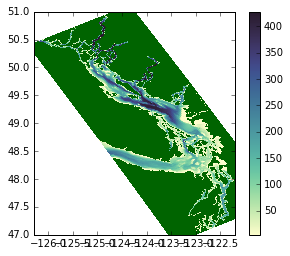

In [4]:
md_bathyfile = nc.Dataset('/home/mdunphy/MEOPAR/WORK/Bathy-201702/bathy_meter_SalishSeaM0.nc')
lon = md_bathyfile.variables['nav_lon']
lat = md_bathyfile.variables['nav_lat']
md_bathy = md_bathyfile.variables['Bathymetry']

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], md_bathy[:], cmap=cmap)
fig.colorbar(mesh, ax=ax)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
depth_check(md_bathy[:])

## Straighten Northern Boundary

In [5]:
ns_bathy = np.copy(md_bathy[:])
js = 37
je = 75

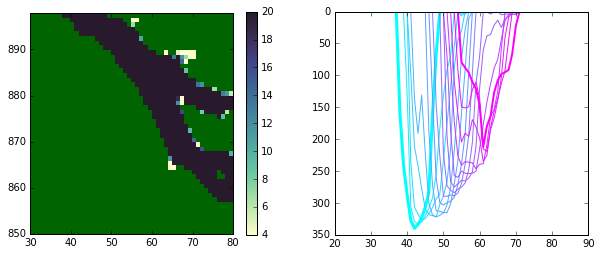

In [6]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ns_masked, cmap=cmap, vmax=20)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((850, 898))
axs[0].set_xlim((30, 80));

axs[1].plot(range(js-10, je+10), ns_bathy[897, js-10:je+10], color=scalarMap.to_rgba(0), linewidth=3)
for i in range(1, 14):
    axs[1].plot(range(js-10, je+10), ns_bathy[897-i, js-10:je+10], color=scalarMap.to_rgba(i))
axs[1].plot(range(js-10, je+10), ns_bathy[897-14, js-10:je+10], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].invert_yaxis()

In [7]:
init_north = np.array(md_bathy[897, :])
# shift north bathymetry 7 points west
north = np.zeros_like(init_north)
north[js:je] = init_north[js-7:je-7]

#first 6 grid points (0-5) use the same, core profile shifted east.  After that merge into the original
#bathymetry, shifting South by half a grid point per grid point east.

# Closest 5 rows to northern boundary, all the same as the boundary
for i in range(898-5, 898):
    ns_bathy[i, js:je] = north[js:je]
# Now move away from the boundary, blending    

i=5; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js:je] + (i-5)/10.*ns_bathy[ii, js:je]
i=6; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-1:je-1] + (i-5)/10.*ns_bathy[ii, js:je]
i=7; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-2:je-2] + (i-5)/10.*ns_bathy[ii, js:je]
i=8; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-3:je-3] + (i-5)/10.*ns_bathy[ii, js:je]
i=9; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-4:je-4] + (i-5)/10.*ns_bathy[ii, js:je]
i=10; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-5:je-5] + (i-5)/10.*ns_bathy[ii, js:je]
i=11; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-6:je-6] + (i-5)/10.*ns_bathy[ii, js:je]
i=12; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-7:je-7] + (i-5)/10.*ns_bathy[ii, js:je]
i=13; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-8:je-8] + (i-5)/10.*ns_bathy[ii, js:je]
i=14; ii=898-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-9:je-9] + (i-5)/10.*ns_bathy[ii, js:je]

In [8]:
# Remove shallow points, deepen points almost at 4
for i in range(880,898):
    for j in range(30,80) :
        if ns_bathy[i, j] < 2:
            ns_bathy[i, j] = 0
        elif ns_bathy[i, j] < 4:
            ns_bathy[i, j] = 4

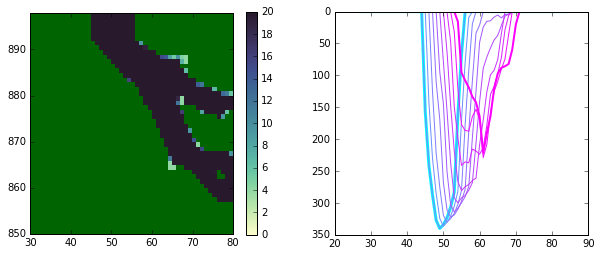

In [9]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ns_masked, cmap=cmap, vmax=20, vmin=0)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((850, 898))
axs[0].set_xlim((30, 80));

axs[1].plot(range(js-10, je+10), ns_bathy[897, js-10:je+10], color=scalarMap.to_rgba(0), linewidth=3)
for i in range(1, 14):
    axs[1].plot(range(js-10, je+10), ns_bathy[897-i, js-10:je+10], color=scalarMap.to_rgba(i))
axs[1].plot(range(js-10, je+10), ns_bathy[897-14, js-10:je+10], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].invert_yaxis()
depth_check(ns_masked[:])

## Straighten Western Boundary

In [10]:
ws_bathy = np.copy(ns_bathy[:])
iss = 350
iee = 470

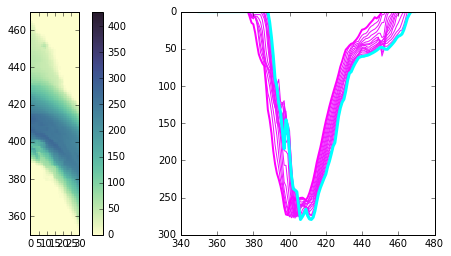

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ws_bathy, cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((350, 470))
axs[0].set_xlim((0, 30));

for j in range(1, 14):
    axs[1].plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(i))
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3)

axs[1].invert_yaxis()

Unlike the North, the mouth profile is kind of jagged.  
A. We'll take out the bank to the south by rearranging the profile and  
B. We'll rearrange the depths in the centre, so that they are a simple up and down: i.e. make the two deep channels into one. At the same time, move the deepest point, one point to the south. This emphasizes the southern channel, which is the channel that continues into Juan de Fuca. We do this so there is no artifical sill in this channel which is not seen in the original bathymetry.

In [12]:
core = np.copy(ws_bathy[:,0])
print (core[iss+43:iss+53])

[ 101.66333008  123.25875854  135.02902052  159.55469259  184.36438497
  145.40374451  155.01451874  191.34469096  220.07521057  238.04792531]


In [13]:
# A. remove bank
core[iss+46] = ws_bathy[iss+48,0]
core[iss+47] = ws_bathy[iss+49,0]
core[iss+48] = ws_bathy[iss+46,0]
core[iss+49] = ws_bathy[iss+47,0]
print (core[iss+43:iss+53])

[ 101.66333008  123.25875854  135.02902052  145.40374451  155.01451874
  159.55469259  184.36438497  191.34469096  220.07521057  238.04792531]


In [ ]:
print (core[401:420])

In [14]:
# B. Fix central channel
core[402] = ws_bathy[403,0]
core[403] = ws_bathy[405,0]
core[404] = ws_bathy[407,0]
core[405] = ws_bathy[406,0]
core[406] = ws_bathy[412,0]
core[407] = ws_bathy[411,0]
core[408] = ws_bathy[413,0] 
core[409] = ws_bathy[410,0]
core[410] = ws_bathy[408,0]
core[411] = ws_bathy[414,0]
core[412] = ws_bathy[409,0]
core[413] = ws_bathy[415,0]
core[414] = ws_bathy[416,0]
core[415] = ws_bathy[404,0]
core[416] = ws_bathy[417,0]
core[417] = ws_bathy[402,0]
print (core[402:417])

[ 239.73733351  261.67866177  275.8232371   279.46614583  279.39492289
  278.7413737   276.5459849   274.51956685  271.60856289  267.96089851
  265.43810696  255.51526896  244.19440884  242.15959676  236.64743296]


In [ ]:
print (core[iss+37:iss+40])
print (core[iee-4:iee-1])


In [15]:
# smooth the west profile, twice
newcore = core
for i in range(iss,iee):
    newcore[i] = 0.25*core[i-1] + 0.5*core[i] + 0.25*core[i+1]
core[:] = newcore
for i in range(360,500):
    newcore[i] = 0.25*core[i-1] + 0.5*core[i] + 0.25*core[i+1]
core[:] = newcore
# rezero iss+37 and iss+38 as we do not want to expand the domain
core[0:iss+38+1] = 0
# rezero iee-4, iee-3,iee-2 as we do not want to expand the domain
print (core[iee-4:iee])
core[iee-3:] = 0
# this domain goes one grid point further north than previous, zero iee-4
core[iee-4] = 0.

[ 5.01224403  1.87385658  0.62366304  0.1904044 ]


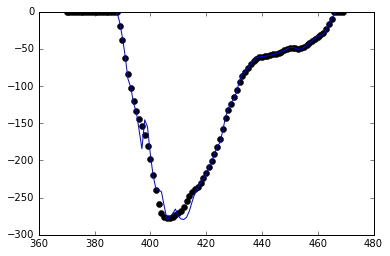

In [16]:
plt.plot(range(370,470),-core[370:470],'ko',range(370,470),-ws_bathy[370:470,0],'-');

We now have "core" which is the bathymetry at the mouth.  This continues 5 more grid points into the domain.  Beyond that we blend into the original bathymetry linearly over the next 10 grid points.  The only difficulty is that we need to follow the bathymetry south-east, so we need to shift south as we go.

In [17]:
for i in range(0,5):
    ws_bathy[370:470,i] = core[370:470]
i=5
ws_bathy[370:470,i] = (-i+15)/10.*core[370:470] + (i-5)/10.*ws_bathy[370:470,i]
i=6
ws_bathy[370:470,i] = (-i+15)/10.*(core[370:470]+core[371:471])/2. + (i-5)/10.*ws_bathy[370:470,i]
i=7
ws_bathy[370:470,i] = (-i+15)/10.*core[371:471] + (i-5)/10.*ws_bathy[370:470,i]
i=8
ws_bathy[370:470,i] = (-i+15)/10.*(core[371:471]+core[372:472])/2. + (i-5)/10.*ws_bathy[370:470,i]
i=9
ws_bathy[370:470,i] = (-i+15)/10.*core[372:472] + (i-5)/10.*ws_bathy[370:470,i]
i=10
ws_bathy[370:470,i] = (-i+15)/10.*(core[372:472]+core[373:473])/2. + (i-5)/10.*ws_bathy[370:470,i]
i=11
ws_bathy[370:470,i] = (-i+15)/10.*core[373:473] + (i-5)/10.*ws_bathy[370:470,i]
i=12
ws_bathy[370:470,i] = (-i+15)/10.*(core[373:473]+core[374:474])/2. + (i-5)/10.*ws_bathy[370:470,i]
i=13
ws_bathy[370:470,i] = (-i+15)/10.*core[374:474] + (i-5)/10.*ws_bathy[370:470,i]
i=14
ws_bathy[370:470,i] = (-i+15)/10.*(core[374:474]+core[375:475])/2. + (i-5)/10.*ws_bathy[370:470,i]


In [18]:
# We have introduced depths that are between 0 and 4.  Choose one or the other
for i in range(iss, iee):
    for j in range (50):
        if ws_bathy[i, j] > 0 and ws_bathy[i, j] < 2 :
            print (i, j, ws_bathy[i, j], 'low')
            ws_bathy[i, j] = 0
        elif ws_bathy[i, j] >= 2 and ws_bathy[i, j] < 4:
            print (i, j, ws_bathy[i, j], 'high')
            ws_bathy[i, j] = 4
            

378 13 3.2 high
379 9 2.07664019267 high
379 10 3.868070364 high
379 11 3.79885959625 high
380 8 1.36009497643 low
380 9 3.66790523529 high
380 12 2.8 high
381 8 1.2 low
381 9 2.53186629613 high
381 10 3.00394312541 high
381 11 3.95879554749 high
382 8 1.2 low
382 9 2.51634407043 high
383 8 1.2 low
383 9 3.73775005341 high
384 8 1.29527025223 low
385 7 0.8 low
385 8 3.45876436234 high
386 6 0.466183137894 low
386 7 1.9085439682 low
387 6 1.58799991608 low
454 14 3.78372546744 high
455 14 3.50990051492 high
456 14 3.28561555284 high
457 14 3.02280815755 high
458 14 2.60460532033 high
459 14 2.00904258085 high
460 13 3.34681415368 high
460 14 1.3425158841 low
461 13 2.02324938272 high
461 14 0.50581234568 low
462 12 1.51743703704 low
463 10 2.5290617284 high
464 8 3.54068641976 high


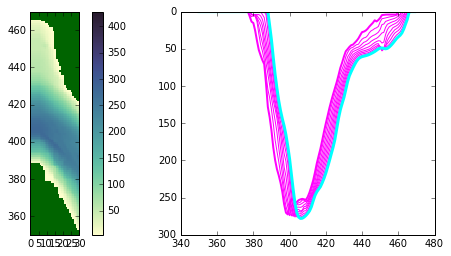

In [19]:
ws_masked = np.ma.masked_array(ws_bathy, ws_bathy == 0)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ws_masked, cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((350, 470))
axs[0].set_xlim((0, 30));

for j in range(1, 14):
    axs[1].plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(i))
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3)

axs[1].invert_yaxis()
depth_check(ws_masked[:])

there is too much extra shallow water in the North.  We can't get rid of all of it, it is partially due to the direct Eastward extension of the boundary, but we can crop some.

In [20]:
top=470
bot=440
left = 3
right = 30

ws_bathy[bot+26,3+left:12+left] = 0
ws_bathy[bot+25,5+left:12+left] = 0
ws_bathy[bot+24,6+left:12+left] = 0
ws_bathy[bot+23,7+left:12+left] = 0
ws_bathy[bot+22,8+left:12+left] = 0
ws_bathy[bot+21,9+left:12+left] = 0
ws_bathy[bot+20,10+left:13+left] = 0
ws_bathy[bot+15:bot+20,11+left:13+left] = 0
ws_bathy[bot+11:bot+15,12+left:14+left] = 0


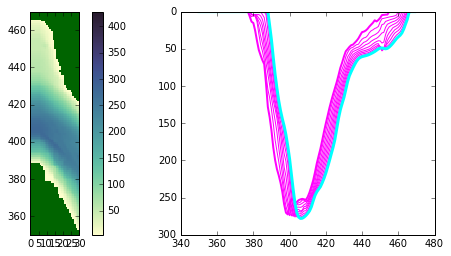

In [21]:
ws_masked = np.ma.masked_array(ws_bathy, ws_bathy == 0)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ws_masked, cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((350, 470))
axs[0].set_xlim((0, 30));

for j in range(1, 14):
    axs[1].plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(i))
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3)

axs[1].invert_yaxis()
depth_check(ws_masked[:])

In [ ]:
print (core[iee-4], ws_bathy[iee-4, 0:4])

## Check continuity and Add Mixed Islands

In [22]:
oc_bathy = np.copy(ws_bathy)

In [23]:
oc_bathy[38, 116] = 0.5*(oc_bathy[38, 117] + oc_bathy[37, 116])
oc_bathy[194, 318] = 0.5*(oc_bathy[193, 318] + oc_bathy[195, 318])
oc_bathy[271, 339] = 0.
oc_bathy[319, 249] = 0.5*(oc_bathy[318, 249] + oc_bathy[320, 249])
oc_bathy[331, 308] = 0.
# End of Saturna Island
oc_bathy[348, 286:289] = 0.
# Tumbo Island
oc_bathy[350, 288:290] = 0.
oc_bathy[351, 287:289] = 0.
oc_bathy[352, 286] = 0.
oc_bathy[353, 285] = 0.
# Russell Island near Fulford Harbour
oc_bathy[366, 232:234] = 0.
# Piers Island near Swartz Bay
oc_bathy[358, 225:227] = 0
# Knapp Island near Swartz Bay
oc_bathy[356, 228] = 0.
# Samuel Island north end of Saturna
oc_bathy[364:367, 271] = 0.
oc_bathy[368, 269] = 0.
# end of Galiano
oc_bathy[428, 240] = 0.
# Newcastle Island
oc_bathy[488:491, 209] = 0.
# Mudge Island
oc_bathy[469, 222] = 0.
oc_bathy[468, 223] = 0.
oc_bathy[467, 224] = 0.
oc_bathy[466, 225:227] = 0.
oc_bathy[465, 226] = 0.
# Twin Islands near Hernando
oc_bathy[724:726, 169] = 0.
# Between West and East Redondo
oc_bathy[763, 221] = 0.5*(oc_bathy[762, 221] + oc_bathy[763, 222])
# North of West thurlow
oc_bathy[849, 131] = 0.5*(oc_bathy[849, 130] + oc_bathy[848, 131])
# Stuart Island
oc_bathy[807, 180] = 0.5*(oc_bathy[807, 179] + oc_bathy[808, 180])
# Boundary Pass Smoothing
oc_bathy[344, 301] = 0.5*(oc_bathy[345, 301] + oc_bathy[344, 300])

In [24]:
depth_check(oc_bathy[:])

### 7. Fix Puget

In [25]:
ps_bathy = np.copy(oc_bathy[:])

In [26]:
# Snohomish river mouth
Fill = [(309,145),(309,144),(310,148),(310,147),(310,146),(310,145),(310,144),(310,143),(310,142),(311,148),(311,147),(311,146),(311,145),(311,144),(311,143),(311,142),(311,141),(312,149),(312,148),(312,147),(312,146),(312,145),(312,144),(312,143),(312,142),(312,141),(312,140),(312,138),(312,137),(313,149),(313,148),(313,147),(313,146),(313,145),(313,144),(313,143),(313,142),(313,141),(313,140),(313,138),(313,137),(314,146),(314,145),(314,144),(314,143),(314,142),(314,141),(314,139),(315,144),(315,143),(315,142),(315,140),(315,139),(316,144),(316,143),(316,141),(316,140),(317,144),(317,143),(317,142),(317,141),(313,139),(314,140),(315,141),(316,142),(318,145),(318,144),(318,143),(318,142),(319,145),(319,144),(319,143),(319,142),(320,145),(320,144),(320,143),(321,143),(318,141)]
#Dabob bay 
Fill += [(198,145),(198,146),(197,146),(199,146),(199,147),(198,147),(197,147),(199,148),(200,148),(198,144),(208,149),(209,149),(207,149),(236,111),(237,111),(180,127),(180,128),(181,128)]
# Near Brinnon and Seabeck
Fill += [(168,119),(167,119),(177,124),(178,124),(179,124),(179,125),(180,125),(180,126),(179,126),(181,112)]
# North Bay
Fill += [(150,59),(150,60),(151,60),(151,59),(152,61),(152,62),(151,61),(153,61),(153,62),(153,63),(153,64),(154,64)]

# Simple fill in with 4m depth here
for i,j in Fill:
    ps_bathy[j,i]=4

ps_masked = np.ma.masked_array(ps_bathy, ps_bathy == 0)

# Down towards Skokomish
Fill2 = [(135,100),(134,98),(133,98),(132,97),(131,97),(131,96),(130,96),(129,96),(127,96),(127,95),(126,95),(125,94),(124,94),(124,93),(123,93),(122,93),(122,92),(121,92),(120,92),(119,91),(118,90),(117,90),(116,89),(115,88),(114,87),(113,87),(112,86),(111,85),(107,77),(109,76),(108,76),(109,75),(106,76),(105,76),(104,76),(103,76),(102,75),(103,75),(104,75),(105,75),(104,74),(103,74),(103,73),(112,72),(114,71),(116,70),(121,70),(122,70),(148,73),(149,73),(150,73),(151,73),(152,73),(153,73),(149,72),(148,71),(150,72),(151,72),(136,73),(107,76)]
# Southern most edge of Puget Sound (Budd Inlet, Oyster Bay, etc)
Fill2 += [(90,13),(90,14),(89,14),(88,14),(88,13),(89,13),(87,13),(86,13),(86,12),(87,14),(85,11),(85,12),(87,23),(87,24),(88,24),(86,24),(86,25),(85,25),(85,24),(84,24),(84,25),(83,25),(83,24),(82,24),(81,24),(80,24),(119,13),(119,12),(119,11),(118,11),(118,10),(100,3),(101,3),(102,4),(102,5),(131,1),(132,1),(132,2),(133,1),(132,0),(133,0),(134,0),(131,0),(154,12),(135,37),(136,37),(136,38),(137,38),(138,38),(118,37),(118,36),(116,38),(118,38)]

# These ones we'll fill with max(4, mean of nearby values)
def chk(bathy,ijlist):
    for i,j in ijlist:
        if ps_masked[j,i] is np.ma.masked: return True
    return False
while(chk(ps_bathy, Fill2)):
    print("Filling pass")
    bathy0 = np.ma.masked_array(np.copy(ps_masked), mask=ps_masked.mask)
    ny, nx = ps_bathy.shape
    for i,j in Fill2:
        i1, i2 = max(0,i-1), min(nx-1,i+1)
        j1, j2 = max(0,j-1), min(ny-1,j+1)
        tmp = bathy0[j1:j2+1,i1:i2+1]
        nzvals = tmp[~tmp.mask].data
        ps_masked[j,i] = max(4, np.mean(nzvals))

Filling pass


/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:35: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


49.1261 -123.774


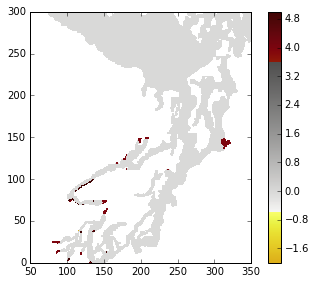

In [27]:
di = 300; dj=300
imin= 0; jmin = 50
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(ps_masked[:] - oc_bathy[:], cmap=cm.oxy_r, vmax=5., vmin=-2)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((imin, imin+di))
ax.set_xlim((jmin, jmin+dj))
plt.plot(180+0.5, 807+0.5, 'rx')
plt.plot(99+0.5, 867+0.5, 'rx')

print (lat[465, 226], lon[465, 226])
depth_check(ps_masked[:])

## Smooth

### (don't) Deep ends of Hood Canal and Dabob Bay

In [28]:
imin, imax = 50, 75
jmin, jmax = 140, 155
dps_bathy = np.copy(ps_bathy)
#for i in range(imin, imax):
#    for j in range(jmin, jmax):
#        if dps_bathy[i, j] < 5 and dps_bathy[i, j] > 0:
#            dps_bathy[i, j] = 5

### Main Smoothing

In [29]:
# lets smooth
ps_masked = np.ma.masked_array(dps_bathy, ps_bathy == 0)
max_dh_over_hbar = 0.8
sm_bathy = bathy_tools.smooth(ps_masked, max_norm_depth_diff=max_dh_over_hbar, smooth_factor=0.2)

In [30]:
depth_check(sm_bathy[:])

### (don't) Extra Smooth Puget

In [31]:
# smooth to 0.7 in south most part of Puget Sound
imin, imax = 0, 100
jmin, jmax = 75, 175
#sm_masked = np.ma.masked_array(sm_bathy, sm_bathy == 0)
#max_dh_over_hbar = 0.7
smp_bathy = np.copy(sm_bathy[:])
#smp_bathy[imin:imax, jmin:jmax] = bathy_tools.smooth(sm_masked[imin:imax, jmin:jmax], max_norm_depth_diff=max_dh_over_hbar, smooth_factor=0.2)

## Add Shallow Jetty

In [32]:
sj_bathy = np.copy(smp_bathy[:])
ibase = 410
jbase = 295

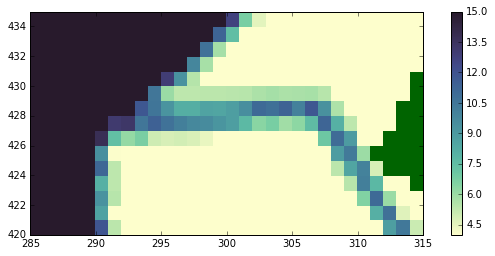

In [33]:
sj_masked = np.ma.masked_array(sj_bathy, sj_bathy == 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 15
vmin = 4
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(sj_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase+10, ibase+25))
ax.set_xlim((jbase-10, jbase+20));



In [34]:
x = np.arange(295, 309); jv_x = np.arange(295, 309); ju_x = 308
y = np.ones(14)*429; jv_y = np.ones(14)*429; ju_y = 429
print (x.shape, y.shape)
x = np.append(x, (308, 309)); jv_x = np.append(jv_x, 309); ju_x = np.append(ju_x, 309)
y = np.append(y, (428, 428)); jv_y = np.append(jv_y, 428); ju_y = np.append(ju_y, 428)
x = np.append(x, (309, 310)); jv_x = np.append(jv_x, 310); ju_x = np.append(ju_x, 310)
y = np.append(y, (427, 427)); jv_y = np.append(jv_y, 427); ju_y = np.append(ju_y, 427)
x = np.append(x, (310, 311)); jv_x = np.append(jv_x, 311); 
y = np.append(y, (426, 426)); jv_y = np.append(jv_y, 426); ju_y = np.append(ju_y, 426)
print (x.shape, y.shape, ju_x.shape)

# make the jetty 4m deep
for j,i in zip(y, x):
    sj_bathy[int(j), i] = 4

(14,) (14,)
(20,) (20,) (3,)


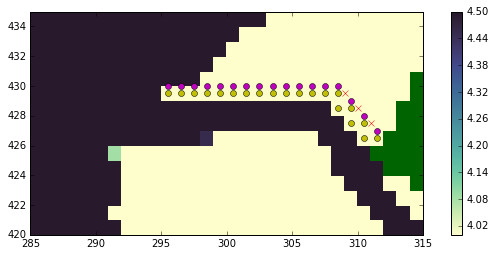

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax=4.5
vmin = 4
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(sj_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase+10, ibase+25))
ax.set_xlim((jbase-10, jbase+20));

for j,i in zip(y,x):
    ax.plot(i+0.5, j+0.5, 'oy')
for j,i in zip(jv_y, jv_x):
    ax.plot(i+0.5, j+1, 'om')
for j,i in zip(ju_y, ju_x):
    ax.plot(i+1, j+0.5, 'xr')
depth_check(sj_masked[:])

## Check Dredged Channel

In [36]:
dc_bathy = np.copy(sj_bathy[:])


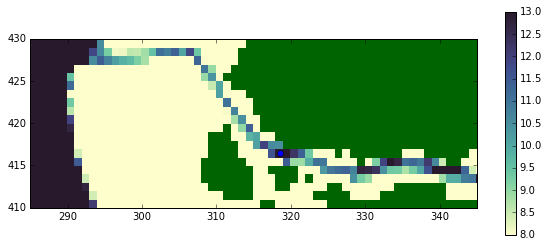

In [37]:
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 13
vmin = 8

viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase, ibase+20))
ax.set_xlim((jbase-10, jbase+50));
ax.plot(jbase+23+0.5, ibase+6+0.5, 'o')


According to: https://voony.files.wordpress.com/2012/10/gmtnauticalchart.jpg

it should be at least 10 m above datum = 13 m above msl deep north of Deas. So I'll make it continuous 13 m throughout.


In [38]:
dc_bathy[ibase+3, jbase+49] = 13
dc_bathy[ibase+3, jbase+48] = 13
dc_bathy[ibase+4, jbase+48] = 13
dc_bathy[ibase+4, jbase+43] = 13
dc_bathy[ibase+5, jbase+43] = 13
dc_bathy[ibase+5, jbase+42] = 13
dc_bathy[ibase+5, jbase+41] = 13
dc_bathy[ibase+5, jbase+40] = 13
dc_bathy[ibase+5, jbase+39] = 13
dc_bathy[ibase+5, jbase+37] = 13
dc_bathy[ibase+4, jbase+37] = 13
dc_bathy[ibase+4, jbase+36] = 13
dc_bathy[ibase+4, jbase+35] = 13
dc_bathy[ibase+4, jbase+34] = 13
dc_bathy[ibase+4, jbase+33] = 13
dc_bathy[ibase+4, jbase+32] = 13
dc_bathy[ibase+4, jbase+31] = 13
dc_bathy[ibase+4, jbase+30] = 13
dc_bathy[ibase+4, jbase+29] = 13
dc_bathy[ibase+5, jbase+29] = 13
dc_bathy[ibase+5, jbase+28] = 13
dc_bathy[ibase+5, jbase+27] = 13
dc_bathy[ibase+6, jbase+27] = 13
dc_bathy[ibase+6, jbase+26] = 13
dc_bathy[ibase+6, jbase+25] = 13
dc_bathy[ibase+6, jbase+22] = 13
dc_bathy[ibase+7, jbase+22] = 13
dc_bathy[ibase+7, jbase+21] = 13
dc_bathy[ibase+7, jbase+20] = 13
dc_bathy[ibase+8, jbase+20] = 13
dc_bathy[ibase+8, jbase+19] = 13
dc_bathy[ibase+9, jbase+19] = 13
dc_bathy[ibase+9, jbase+18] = 13
dc_bathy[ibase+10, jbase+18] = 13
dc_bathy[ibase+10, jbase+17] = 13
dc_bathy[ibase+11, jbase+17] = 13
dc_bathy[ibase+11, jbase+16] = 13
dc_bathy[ibase+12, jbase+16] = 13
dc_bathy[ibase+13, jbase+16] = 13
dc_bathy[ibase+13, jbase+15] = 13
dc_bathy[ibase+14, jbase+15] = 13
dc_bathy[ibase+14, jbase+14] = 13
dc_bathy[ibase+15, jbase+14] = 13
dc_bathy[ibase+16, jbase+14] = 13
dc_bathy[ibase+16, jbase+13] = 13
dc_bathy[ibase+17, jbase+13] = 13
dc_bathy[ibase+17, jbase+12] = 13
dc_bathy[ibase+18, jbase+12] = 13
dc_bathy[ibase+18, jbase+7:jbase+12] = 13
dc_bathy[ibase+18, jbase+6] = 13
dc_bathy[ibase+18, jbase+5] = 13
dc_bathy[ibase+18, jbase+4] = 13
dc_bathy[ibase+18, jbase+3] = 13
dc_bathy[ibase+17, jbase+3] = 13
dc_bathy[ibase+17, jbase+2] = 13
dc_bathy[ibase+17, jbase+1] = 13
dc_bathy[ibase+17, jbase] = 13
dc_bathy[ibase+17, jbase-1] = 13
dc_bathy[ibase+17, jbase-2] = 13

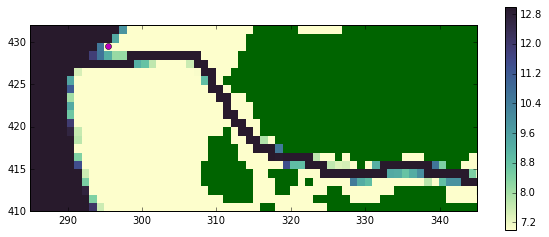

In [39]:
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 13
vmin = 7
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase, ibase+22))
ax.set_xlim((jbase-10, jbase+50));
ax.plot(x[0]+0.5, y[0]+0.5, 'om')

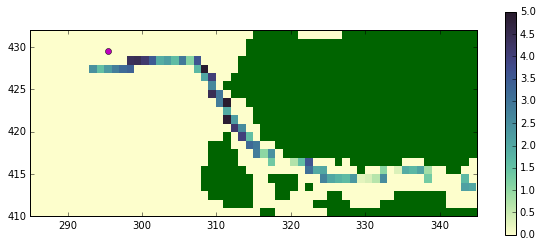

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 5
vmin = 0
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(dc_masked-sj_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase, ibase+22))
ax.set_xlim((jbase-10, jbase+50));
ax.plot(x[0]+0.5, y[0]+0.5, 'om')
depth_check(dc_masked[:])

## Final Bathymetry

In [41]:
final_bathy = dc_masked

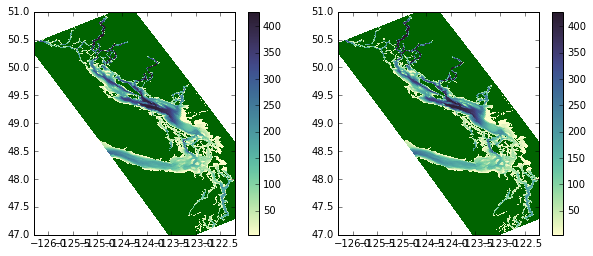

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
viz_tools.set_aspect(axs[0], coords='map')
mesh = axs[0].pcolormesh(lon[:], lat[:], md_bathy[:], cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim(ylim)
axs[0].set_xlim(xlim)
viz_tools.set_aspect(axs[1], coords='map')
mesh = axs[1].pcolormesh(lon[:], lat[:], final_bathy[:], cmap=cmap)
fig.colorbar(mesh, ax=axs[1])
axs[1].set_ylim(ylim)
axs[1].set_xlim(xlim);

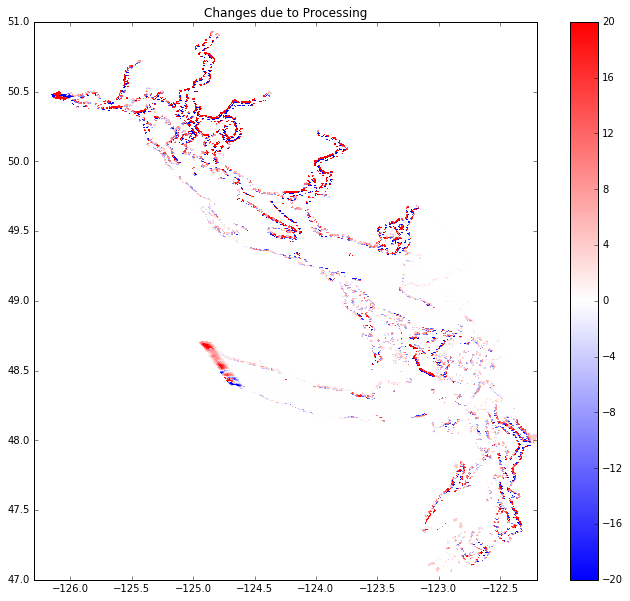

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(md_bathy[:]), cmap='bwr', vmax=20, vmin=-20)
fig.colorbar(mesh, ax=ax)
ax.set_ylim(ylim)
ax.set_title('Changes due to Processing')
ax.set_xlim(xlim);

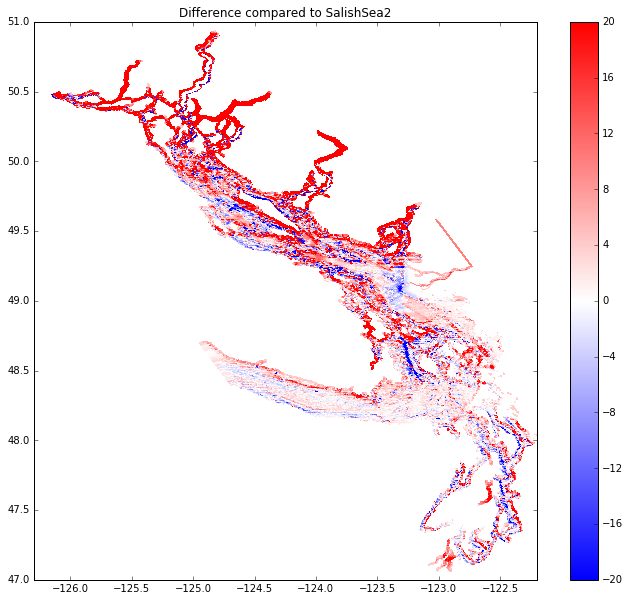

In [44]:
ss2_file = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
ss2_bathy = ss2_file.variables['Bathymetry']
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(ss2_bathy[:]), cmap='bwr', vmax=20, vmin=-20)
fig.colorbar(mesh, ax=ax)
ax.set_title('Difference compared to SalishSea2')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ss2_file.close()

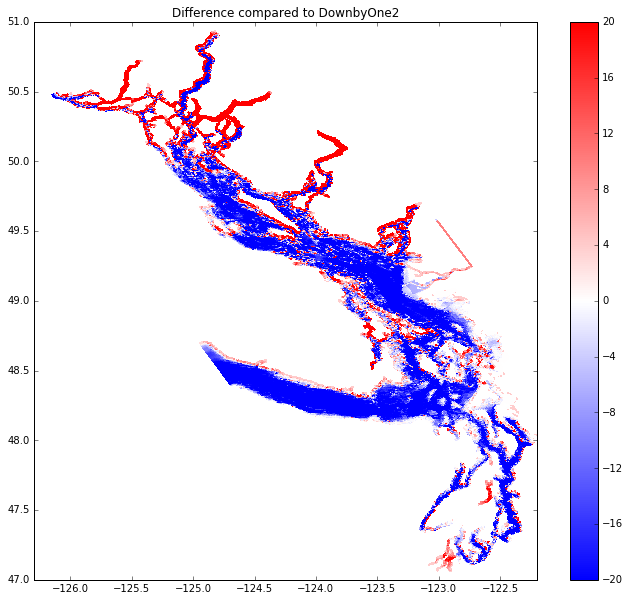

In [45]:
db1_file = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
db1_bathy = db1_file.variables['Bathymetry']
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(db1_bathy[:]), cmap='bwr', vmax=20, vmin=-20)
fig.colorbar(mesh, ax=ax)
ax.set_title('Difference compared to DownbyOne2')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
db1_file.close()

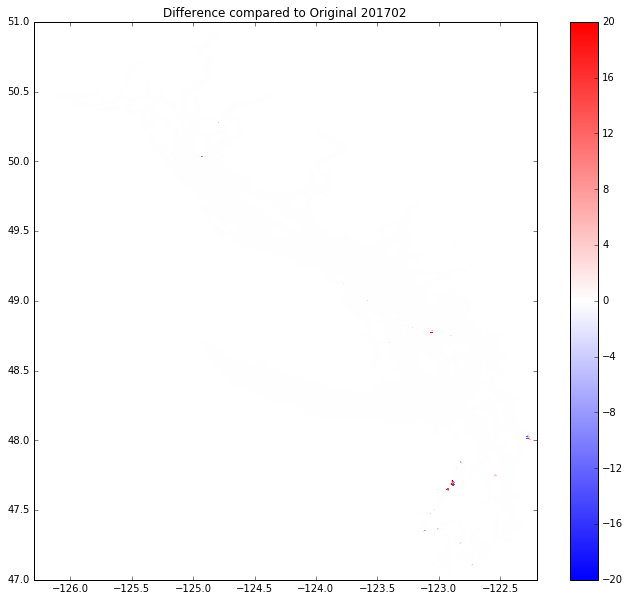

In [46]:
tos_file = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
tos_bathy = tos_file.variables['Bathymetry'][:]
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-tos_bathy, cmap='bwr', vmax=20, vmin=-20)
fig.colorbar(mesh, ax=ax)
ax.set_title('Difference compared to Original 201702')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
db1_file.close()

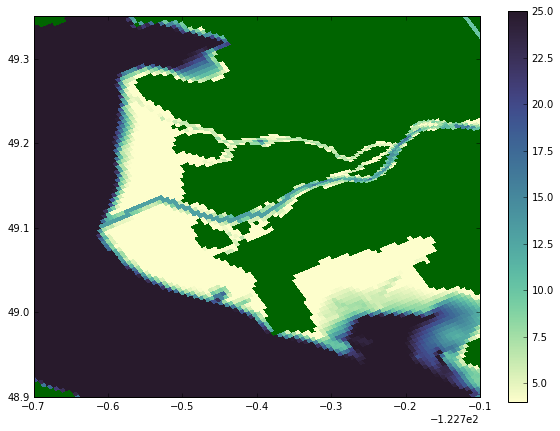

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy[:], cmap=cmap ,vmax=25, vmin=4)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((48.9, 49.35))
ax.set_xlim((-123.4, -122.8));

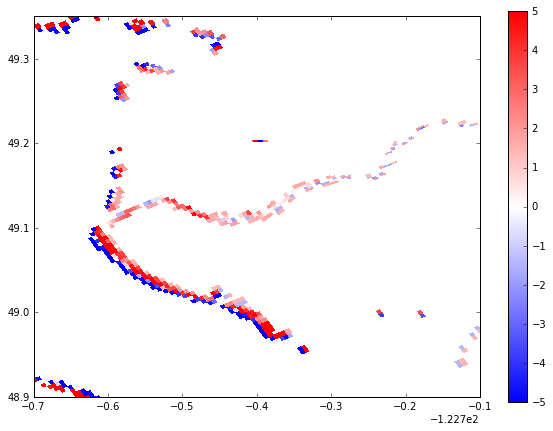

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy[:]-md_bathy[:], cmap='bwr' ,vmax=5, vmin=-5)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((48.9, 49.35))
ax.set_xlim((-123.4, -122.8));

## Write out ##

In [49]:
nc_tools.show_dataset_attrs(md_bathyfile)

file format: NETCDF4


In [50]:
ysize = final_bathy.shape[0]; xsize = final_bathy.shape[1]
print (ysize, xsize)

898 398


In [51]:
bathy201702 = nc.Dataset('./bathymetry_20170.nc', 'w')
bathy201702.createDimension('y', ysize)
bathy201702.createDimension('x', xsize)
nc_tools.show_dimensions(bathy201702)

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398



In [52]:
newlons = bathy201702.createVariable('nav_lon', float, ('y', 'x'), zlib=True)
newlons.setncattr('units', 'degrees_east')
newlons.setncattr('long_name', 'longitude')
newlats = bathy201702.createVariable('nav_lat', float, ('y', 'x'), zlib=True)
newlats.setncattr('units', 'degrees_north')
newlats.setncattr('long_name', 'latitude')

newdepths = bathy201702.createVariable(
    'Bathymetry', float, ('y', 'x'), 
    zlib=True, least_significant_digit=0.1, fill_value=0)
newdepths.setncattr('units', 'metres')
newdepths.setncattr('long_name', 'sea_floor_depth')

newlons[:] = lon
newlats[:] = lat
newdepths[:] = final_bathy

In [53]:
nc_tools.init_dataset_attrs(bathy201702, 'Bathymetry 201702', 'ProcessNewRiverBathymetry',
                           'sea_initial/bathymetry_201702.nc', 
                            'Bathymetry processed from Michaels New Full River Bathymetry with correction on smoothing')

file format: NETCDF4
Conventions: CF-1.6
title: Bathymetry 201702
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/ProcessNewRiverBathymetry.ipynb
references: REQUIRED
history: [2017-12-19 10:38:00] Created netCDF4 zlib=True dataset.
comment: Bathymetry processed from Michaels New Full River Bathymetry with correction on smoothing


In [54]:
bathy201702.setncattr('references', 'sea_initial/bathymetry_201702.nc')

In [55]:
nc_tools.check_dataset_attrs(bathy201702)

In [56]:
nc_tools.show_dataset_attrs(bathy201702)

file format: NETCDF4
Conventions: CF-1.6
title: Bathymetry 201702
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/ProcessNewRiverBathymetry.ipynb
references: sea_initial/bathymetry_201702.nc
history: [2017-12-19 10:38:00] Created netCDF4 zlib=True dataset.
comment: Bathymetry processed from Michaels New Full River Bathymetry with correction on smoothing


In [57]:
bathy201702.close()

## Jetty Mask ##

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


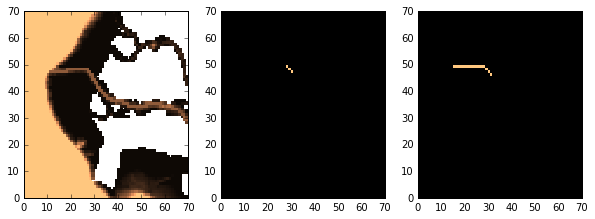

In [197]:
mask_for_jetty_u = np.zeros_like(ns_bathy)
mask_for_jetty_v = np.zeros_like(ns_bathy)
for j, i in zip(jv_y, jv_x):
    mask_for_jetty_v[j, i]= 1.0
for j, i in zip(ju_y, ju_x):
    mask_for_jetty_u[j, i] = 1.0
fig, ax = plt.subplots(1, 3, figsize=(10,5))
viz_tools.set_aspect(ax[0])
viz_tools.set_aspect(ax[1])
viz_tools.set_aspect(ax[2])
ax[0].pcolormesh(final_bathy[380:450, 280:350], cmap='copper', vmax=25, vmin=3)
ax[1].pcolormesh(mask_for_jetty_u[380:450, 280:350], cmap='copper', vmax=1, vmin=0)
ax[2].pcolormesh(mask_for_jetty_v[380:450, 280:350], cmap='copper', vmax=1, vmin=0);

### Reduced Friction

-0.00125

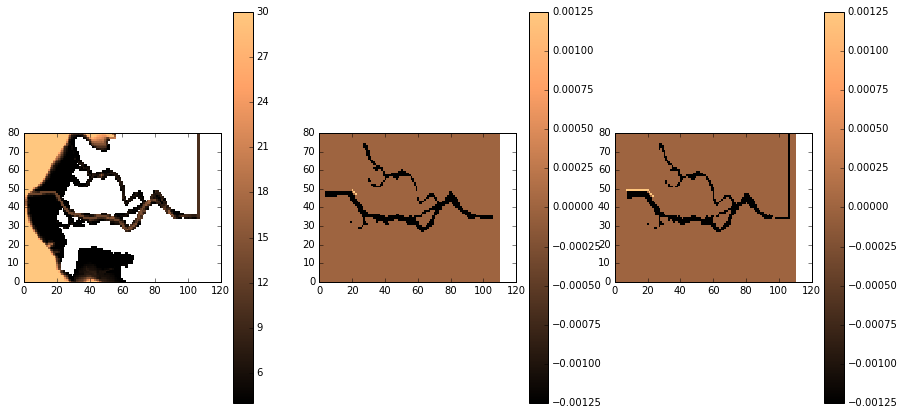

In [198]:
# this is a hack assuming rn_bfrien is set to 400!!!
value = -0.5/400.
imin, imax = 405, 460
jmin, jmax = 288+60, 398
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if final_bathy[i, j] + final_bathy[i+1, j] > 2*4:
            mask_for_jetty_v[i, j] = value    # watch, v is in i-direction!
        if j+1 < 398 and final_bathy[i, j] + final_bathy[i, j+1] > 2*4:
            mask_for_jetty_u[i, j] = value
            
imin, imax = 405, 450
jmin, jmax = 318, 288+60
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if final_bathy[i, j] + final_bathy[i+1, j] > 2*4:
            mask_for_jetty_v[i, j] = value    # watch, v is in i-direction!
        if final_bathy[i, j] + final_bathy[i, j+1] > 2*4:
            mask_for_jetty_u[i, j] = value
imin, imax = 438, 455
jmin, jmax = 315, 328
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if final_bathy[i, j] + final_bathy[i+1, j] > 2*4:
            mask_for_jetty_v[i, j] = value    # watch, v is in i-direction!
        if final_bathy[i, j] + final_bathy[i, j+1] > 2*4:
            mask_for_jetty_u[i, j] = value
imin, imax = 408, 429
jmin, jmax = 288+8, 325
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if final_bathy[i, j] + final_bathy[i+1, j] > 2*4:
            mask_for_jetty_v[i, j] = value    # watch, v is in i-direction!
        if final_bathy[i, j] + final_bathy[i, j+1] > 2*4:
            mask_for_jetty_u[i, j] = value
imin, imax = 425, 429
jmin, jmax = 288+4, 288+15
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if final_bathy[i, j] + final_bathy[i, j+1] > 2*4:
            mask_for_jetty_u[i, j] = value
imin, imax = 380, 460
jmin, jmax = 288, 398
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
viz_tools.set_aspect(ax[0])
viz_tools.set_aspect(ax[1])
viz_tools.set_aspect(ax[2])
mesh = ax[0].pcolormesh(final_bathy[imin:imax, jmin:jmax], cmap='copper', vmax=30, vmin=4)
fig.colorbar(mesh, ax=ax[0])
mesh = ax[1].pcolormesh(mask_for_jetty_u[imin:imax, jmin:jmax], cmap='copper', vmax=-value, vmin=value)
fig.colorbar(mesh, ax=ax[1])
mesh = ax[2].pcolormesh(mask_for_jetty_v[imin:imax, jmin:jmax], cmap='copper', vmax=-value, vmin=value)
fig.colorbar(mesh, ax=ax[2]);
value

In [207]:
jetty_mask = nc.Dataset('./jetty_mask_bathy201702_rbf.nc', 'w')
jetty_mask.createDimension('y', ysize)
jetty_mask.createDimension('x', xsize)
nc_tools.show_dimensions(jetty_mask)

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398



In [209]:
newlons = jetty_mask.createVariable('nav_lon', float, ('y', 'x'), zlib=True)
newlons.setncattr('units', 'degrees_east')
newlons.setncattr('long_name', 'longitude')
newlats = jetty_mask.createVariable('nav_lat', float, ('y', 'x'), zlib=True)
newlats.setncattr('units', 'degrees_north')
newlats.setncattr('long_name', 'latitude')

friction_mask_u = jetty_mask.createVariable(
    'bfr_coef_u', float, ('y', 'x'), 
    zlib=True, fill_value=-99)
friction_mask_u.setncattr('units', 'none')
friction_mask_u.setncattr('long_name', 'friction_x_binary_mask')
friction_mask_v = jetty_mask.createVariable(
    'bfr_coef_v', float, ('y', 'x'), 
    zlib=True, fill_value=-99)
friction_mask_v.setncattr('units', 'none')
friction_mask_v.setncattr('long_name', 'friction_y_binary_mask')

In [210]:
newlons[:] = lon
newlats[:] = lat
friction_mask_u[:] = mask_for_jetty_u[:]
friction_mask_v[:] = mask_for_jetty_v[:]
print(np.min(mask_for_jetty_u))
print(np.min(friction_mask_u[:]))

-0.00125
-0.00125


In [211]:
nc_tools.init_dataset_attrs(jetty_mask, 'Jetty Mask for Bathy 201702 reduced bottom friction', 'ProcessNewRiverBathymetry',
                           'sea_initial/v201702_alternate_bathys/jetty_mask_bathy201702_rbf', 
                            'Bathymetry processed from Michaels New Full River Bathymetry reduced bottom friction')

file format: NETCDF4
Conventions: CF-1.6
title: Jetty Mask for Bathy 201702 reduced bottom friction
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/ProcessNewRiverBathymetry.ipynb
references: REQUIRED
history: [2017-12-19 15:25:54] Created netCDF4 zlib=True dataset.
comment: Bathymetry processed from Michaels New Full River Bathymetry reduced bottom friction


In [212]:
jetty_mask.setncattr('references', 'sea_initial/v201702_alternate_bathys/jetty_mask_bathy201702_rbf.nc')

In [213]:
nc_tools.check_dataset_attrs(jetty_mask)

In [214]:
nc_tools.show_dataset_attrs(jetty_mask)

file format: NETCDF4
Conventions: CF-1.6
title: Jetty Mask for Bathy 201702 reduced bottom friction
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/ProcessNewRiverBathymetry.ipynb
references: sea_initial/v201702_alternate_bathys/jetty_mask_bathy201702_rbf.nc
history: [2017-12-19 15:25:54] Created netCDF4 zlib=True dataset.
comment: Bathymetry processed from Michaels New Full River Bathymetry reduced bottom friction


In [215]:
jetty_mask.close()

In [ ]:
di = 50; dj=50
imin = 0; jmin = 80
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(final_bathy[:], cmap=cmap, vmax=25)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((imin, imin+di))
ax.set_xlim((jmin, jmin+dj))
plt.plot(180+0.5, 807+0.5, 'rx')
plt.plot(99+0.5, 867+0.5, 'rx')

print (lat[465, 226], lon[465, 226])

In [ ]:
original_file = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
new_file = nc.Dataset('./bathymetry_201702b.nc')
deptho = original_file.variables['Bathymetry']
depthn = new_file.variables['Bathymetry']

In [ ]:
for i in range(898):
    for j in range(398):
        if (depthn[i, j] != deptho[i, j]):
            print(i, j, depthn[i, j], deptho[i, j])
            if (abs(depthn[i,j]-deptho[i,j]) > 1):
                print('****')

In [ ]:
di=100; dj=100
fig, axs = plt.subplots(36, 3, figsize=(15, 180))
plot = 0
for row in range(9):
    i = di*row
    for column in range(4):
        j = dj*column
        axs[plot, 0].pcolormesh(deptho[i:i+di, j:j+dj], cmap=cmap, vmax=50)
        axs[plot, 1].pcolormesh(depthn[i:i+di, j:j+dj], cmap=cmap, vmax=50)
        axs[plot, 2].pcolormesh(np.array(depthn[i:i+di, j:j+dj]) - 
                                np.array(deptho[i:i+di, j:j+dj]), cmap='bwr', vmax=10, vmin=-10)
        axs[plot, 0].set_title('At '+str(i)+' and '+str(j))
        plot += 1

In [ ]:
original_file.close()
new_file.close()